# Appendix A3: Bessel low-pass filters
**Appendix A provides extra background for path clamp electronics.**

[Bessel filters](https://en.wikipedia.org/wiki/Bessel_filter) are popular for low-pass filtering in patch clamp hardware and software.

## Transfer function

The transfer function for a Bessel low-pass filter has a [reverse Bessel polynomial](https://en.wikipedia.org/wiki/Bessel_polynomials) as its denominator, and a numerator which acts as a scaling term to achieve unity gain for $s = 0$.

In mathematical notation, a Bessel low-pass filter of **order $n$** has transfer function:

\begin{align}
H(s) = \frac{\theta_n(0)}{\theta_n(s)}
\end{align}
where
\begin{align}
\theta_n(x) = \sum_{k=0}^{n} \frac{(2n - k)!}{2^{n-k}(n - k)!k!} x^k
            = \sum_{k=0}^{n} \alpha_{n,k} x^{n-k}
\end{align}

For example, a third order Bessel filter has transfer function
\begin{align}
H(s) = \frac{\alpha_{3, 0}}{\alpha_{3, 3} s^3 + \alpha_{3, 2} s^2 + \alpha_{3, 1} s + \alpha_{3, 0}}
\end{align}
where $\alpha_{3, 0}=15$, $\alpha_{3, 1}=15$, $\alpha_{3, 2}=6$, and $\alpha_{3, 0}=1$ for
\begin{align}
H(s) = \frac{15}{s^3 + 6s^2 + 15s + 15}
\end{align}

### Example transfer functions

Finding $\alpha_{n,k}$ is easiest with a script:

In [1]:
import numpy as np

def revbes(n):
    """ Returns the coefficients for a reverse Bessel polynomial. """
    f = np.math.factorial
    return [int(f(2 * n - k) / (2**(n - k)*f(n - k) * f(k)))
            for k in range(n + 1)]
    
print(revbes(3))

[15, 15, 6, 1]


This lets us find the first six filters as:

In [2]:
for i in range(1, 7):
    print(i, revbes(i))

1 [1, 1]
2 [3, 3, 1]
3 [15, 15, 6, 1]
4 [105, 105, 45, 10, 1]
5 [945, 945, 420, 105, 15, 1]
6 [10395, 10395, 4725, 1260, 210, 21, 1]


\begin{align}
H_1(s) &= \frac{1}{s + 1} \\
H_2(s) &= \frac{3}{s^2 + 3s + 3} \\
H_3(s) &= \frac{15}{s^3 + 6s^2 + 15s + 15} \\
H_4(s) &= \frac{105}{s^4 + 10s^3 + 45s^2 + 105s + 105} \\
H_5(s) &= \frac{945}{s^5 + 15s^4 + 105s^3 + 420s^2 + 945s + 945} \\
H_6(s) &= \frac{10395}{s^6 + 21s^5 + 210s^4 + 1260s^3 + 4725s^2 + 10395s + 10395}
\end{align}

## The cut-off frequency

To design a Bessel filter with a particular cut-off frequency, we:

1. Decide on an _attenuation level_, for example the famous "3[dB](https://en.wikipedia.org/wiki/Decibel) point": $^{10}\log(1/2) \approx -3.01$.
2. Using $|H(i\omega)|$ to find a frequency $\omega$ where the filter has the desired attenuation (typically numerically, e.g. with root-finding).
3. Scale $s$.

## Poles
**Note**: Some sources say the poles lie on the unit circle: they do not.

To find the poles of a Bessel filter, we can use [partial fraction decomposition](https://en.wikipedia.org/wiki/Partial_fraction_decomposition) on the equations shown above.
We can also make life easier, and ask SciPy to approximate them numerically with the function [`scipy.signal.bessel`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bessel.html).

Unfortunately the function to do this has a lot of arguments. The main ones are:
- `N`: The order of the filter
- `Wn`: When `norm=phase` and `analog=True` this is the angular "critical frequency". To get solutions to the equatiosn above, we use `Wn=1`
- `btype`: Filter type, we leave this at the default of `lowpass`.
- `analog`: In the above, we're assuming an analog filter, that is, a filter that operates on a continuous signal. Later we will set this to `digital` to create filters we can use on a sampled filter.
- `output`: Set this to `zpk` to obtain the zeroes (z), poles (p), and a gain factor (k).
- `delay`: Set this to `delay`, to get "the natural type obtained by solving Bessel polynomials".

Let's try for a filter with n=1:

In [3]:
import scipy.signal

z, p, k = scipy.signal.bessel(1, 1, output='zpk', analog=True, norm='delay')
print(z)
print(p)
print(k)

[]
[-1.-0.j]
1.0


So no zeroes, a pole at $s = -1$ and a gain factor $1$

For this filter we had
\begin{align}
H(s) &= \frac{1}{s + 1}
\end{align}
so this checks out!

Note that the lack of zeroes makes sense as well: we can see this directly from the original transfer function.

Now we can try for $n=2$:

In [4]:
z, p, k = scipy.signal.bessel(2, 1, output='zpk', analog=True, norm='delay')
print(p)
print(k)

[-1.5+0.8660254j -1.5-0.8660254j]
3.0


So no zeroes, a gain of 3, and poles at $-1.5 \pm i\sqrt{3}/2$ (where we did a bit of guesswork to equate 0.8660254 with $\sqrt{3}/2$).

Filling in, and using $(a - bi)(a + bi) = a^2 + b^2$, we find:
\begin{align}
H(s) &= \frac{3}{(s + 1.5 - i\sqrt{3}/2)(s + 1.5 + i\sqrt{3}/2)} \\
     &= \frac{3}{(s + 3/2)^2 + 3/4} \\
     &= \frac{3}{s^2 + 3s + 3} \\
\end{align}

We can go crazy and do it for the next one up:

In [5]:
z, p, k = scipy.signal.bessel(3, 1, output='zpk', analog=True, norm='delay')
print(p)
print(k)

[-1.83890732+1.75438096j -2.32218535-0.j         -1.83890732-1.75438096j]
15.0


Comparing with 
\begin{align}
H(s) &= \frac{15}{s^3 + 6s^2 + 15s + 15}
\end{align}
we can immediately see that the "gain" of 15 is correct.

Guessing what fractions 1.83890732, 1.75438096, and 2.32218535 approximate is harder, so instead we write out the equation for denominator $D$ symbolically, using $a\approx1.83890732$, $b\approx1.75438096$, and $c\approx2.32218535$:

\begin{align}
D &= (s + a - bi)(s + a + bi)(s + c) \\
&= ((s + a)^2 + b^2))(s + c) \\
&= (s^2 + a^2 + 2as + b^2)(s + c) \\
&= (s^2 + a^2 + 2as + b^2)(s + c) \\
&= s^3 + a^2s + 2as^2 + b^2s + cs^2 + a^2c + 2acs + b^2c \\
&= s^3 + (2a + c)s^2 + (a^2 + b^2 + 2ac)s + c(a^2 + b^2)
\end{align}


In [6]:
a = -p[0].real
b = p[0].imag
c = -p[1].real

print(2*a + c)
print(a**2 + b**2 + 2*a*c)
print(c*(a**2 + b**2))

6.0
14.999999999999996
14.999999999999995


So these coefficients are within machine precision of 6, 15, 15 and this one again checks out!

## Frequency response and Bode plots

To work out a Bessel filter's frequency response we need to evaluate $|H(i\omega)|$ and $\angle H(i\omega)$.

Luckily, Python can do this for us.

In [7]:
def mag(w):
    x = 0 + 1j * w
    return np.abs(15 / (x**3 + 6*x**2 + 15*x + 15))
    
def arg(w):
    x = 0 + 1j * w
    return -np.angle(15 / (x**3 + 6*x**2 + 15*x + 15))

We can then use the method from a previous appendix to create a Bode plot:

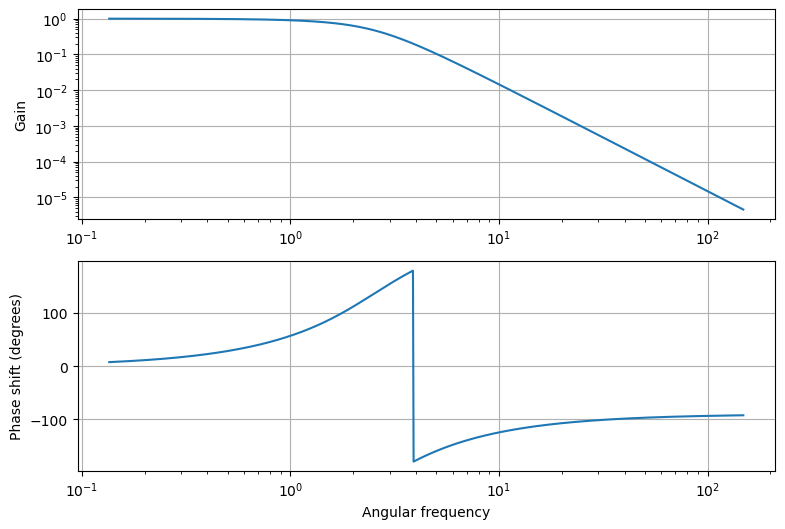

In [8]:
import matplotlib.pyplot as plt
from library import bode
axes = bode(mag, arg)
plt.show()    

If we're not worried about performance, we can even write these methods as a function of the order $n$:

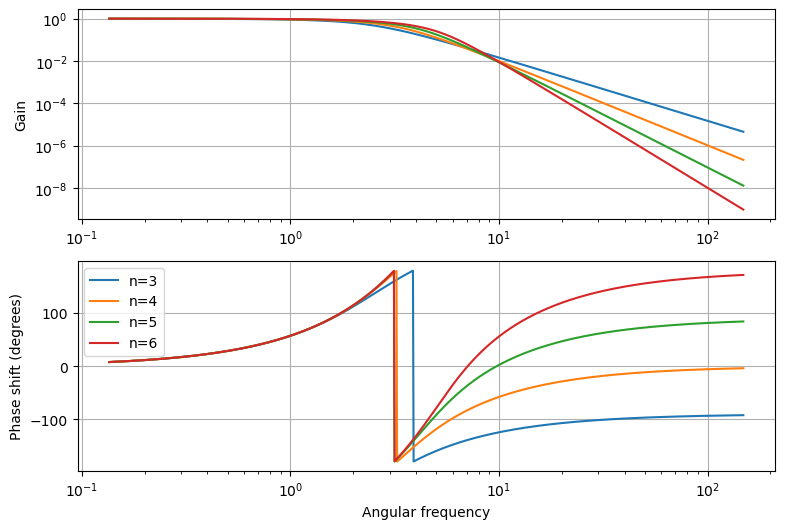

In [27]:
def bes(w, n):
    x = 0 + 1j * w
    a = revbes(n)
    b = np.array([x**i for i in range(1 + n)])
    return a[0] / np.sum(a * b.T, axis=1)

def mag(w, n):
    return np.abs(bes(w, n))
    
def arg(w, n):
    return -np.angle(bes(w, n))

axes = bode(mag, arg, n=3)
axes = bode(mag, arg, n=4, axes=axes)
axes = bode(mag, arg, n=5, axes=axes)
axes = bode(mag, arg, n=6, axes=axes)
plt.show()    

We can compare the top plot with the scipy version:

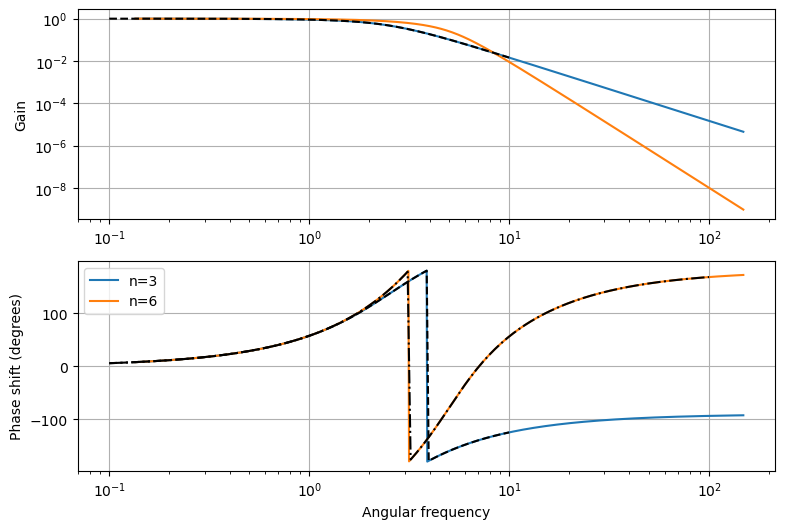

In [55]:
axes = bode(mag, arg, n=3)
axes = bode(mag, arg, n=6, axes=axes)
ax0, ax1 = axes

b, a = scipy.signal.bessel(3, 1, analog=True, norm='delay')
w, h = scipy.signal.freqs(b, a)
ax0.plot(w, np.abs(h), 'k--')
ax1.plot(w, -np.angle(h) * 180 / np.pi, 'k--')

b, a = scipy.signal.bessel(6, 1, analog=True, norm='delay')
w, h = scipy.signal.freqs(b, a)
ax1.plot(w, -np.angle(h) * 180 / np.pi, 'k-.')

plt.show()

This confirms that the SciPy `bessel` function with `Wn=1`, `analog=True`, and `norm='delay' is the canonical "Bessel filter" described by the transfer functions above.

## Emulating an analog filter

We can also use SciPy to emulate the effects of an analog filter on an analog signal, although we represent it here as a digital (sampled) signal!

For this, we use the method [lsim](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lsim.html).

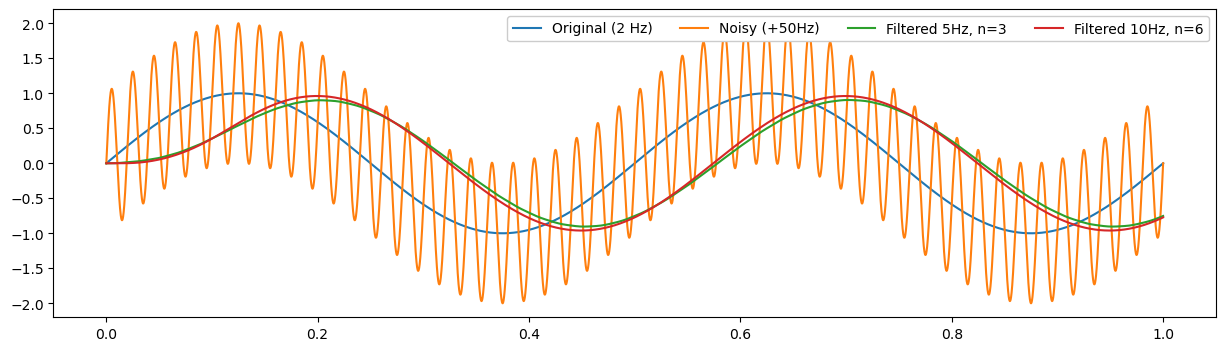

In [77]:
t = np.linspace(0, 1, 10001)
f = 1 / t[1]   # Sampling frequency, in Hz

def sin(x, w):
    """ Return a sine wave with frequency w (in Hz). """
    return np.sin(2 * np.pi * w * x)

def low_pass(time, data, w, n=3):
    """
    Emulate an analog Bessel low-pass filter with cut-off w (in Hz).
    
    Returns a tuple ``(t, y)``.
    """
    b, a = scipy.signal.bessel(n, 2 * np.pi * w, btype='lowpass', analog=True)
    t, y, _ = scipy.signal.lsim((b, a), data, time)
    return t, y

x = sin(t, 2)
y = x + sin(t, 50)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(t, x, label='Original (2 Hz)')
ax.plot(t, y, label='Noisy (+50Hz)')
ax.plot(*low_pass(t, y, w=5, n=3), label='Filtered 5Hz, n=3')
ax.plot(*low_pass(t, y, w=10, n=6), label='Filtered 10Hz, n=6')
ax.legend(ncol=4, framealpha=1)
plt.show()

Both filters cause quite a phase shift, but otherwise work well.

## Digital filter

We can also apply a digital filter.

This time we use:

- Order `n`
- A frequency, _expressed as a fraction of the Nyquist frequency_, which means it's a fraction of _half the sampling frequency_. Yup.
- Analog `False`

And for the filtering we use [lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html#scipy.signal.lfilter).

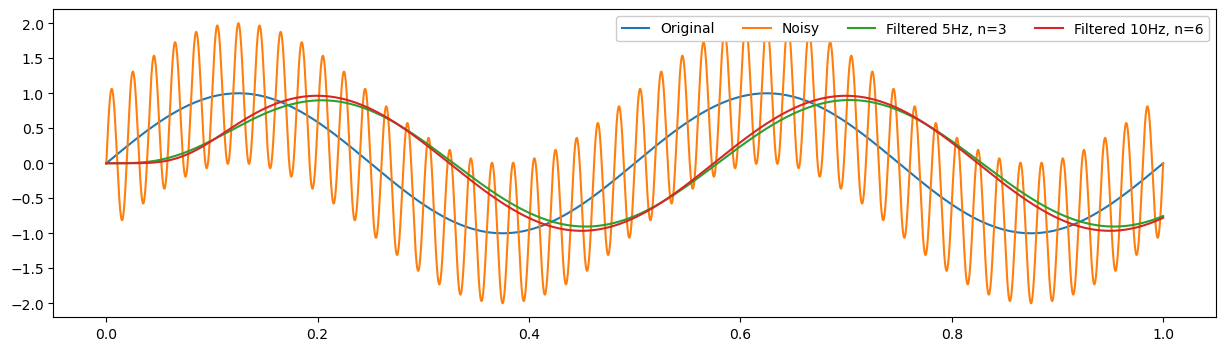

In [78]:
t = np.linspace(0, 1, 10001)
f = 1 / t[1]   # Sampling frequency, in Hz
w = 50         # Cut-off frequency, in Hz

def sin(x, f):
    """ Draw a sine wave with frequency f. """
    return np.sin(2 * np.pi * f * x)

def low_pass(data, w, f, n=3):
    """ Apply a Bessel low-pass filter with cut-off w (in Hz). """
    # Convert the frequency to a fraction of the Nyquist
    # frequency f/2
    w = w / (f / 2)
    b, a = scipy.signal.bessel(n, w)
    return scipy.signal.lfilter(b, a, data)

x = sin(t, 2)
y = x + sin(t, 50)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(t, x, label='Original')
ax.plot(t, y, label='Noisy')
ax.plot(t, low_pass(x, 5, f, n=3), label='Filtered 5Hz, n=3')
ax.plot(t, low_pass(x, 10, f, n=6), label='Filtered 10Hz, n=6')
ax.legend(ncol=4, framealpha=1)
plt.show()

If we're interested in getting the best result (instead of emulating real filters), we can use the method [filtfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html) instead. This applies a digital filter "forwards" and then "backwards", meaning it is twice as slow but has (A) zero phase shift and (B) twice the order of the original.

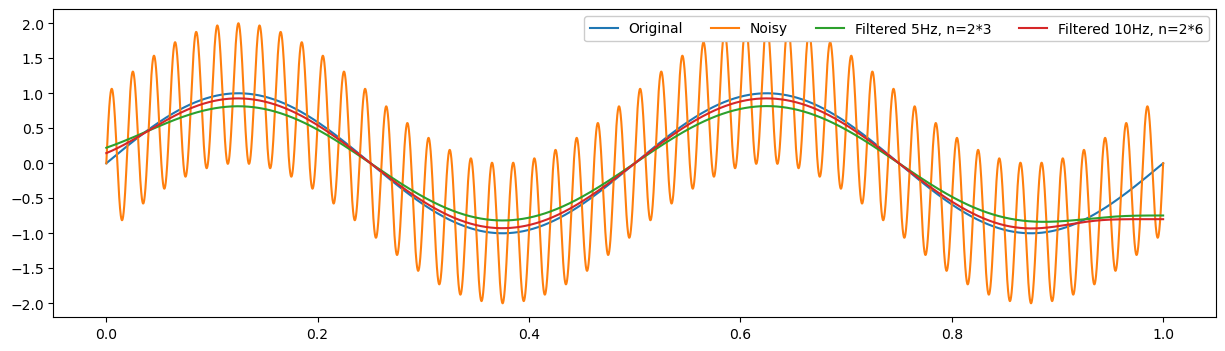

In [79]:
def low_pass(data, w, f, n=3):
    """ Apply a Bessel low-pass filter with cut-off w (in Hz) twice. """
    w = w / (f / 2)
    b, a = scipy.signal.bessel(n, w)
    return scipy.signal.filtfilt(b, a, data)

x = sin(t, 2)
y = x + sin(t, 50)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(t, x, label='Original')
ax.plot(t, y, label='Noisy')
ax.plot(t, low_pass(x, 5, f, n=3), label='Filtered 5Hz, n=2*3')
ax.plot(t, low_pass(x, 10, f, n=6), label='Filtered 10Hz, n=2*6')
ax.legend(ncol=4, framealpha=1)
plt.show()

## ODE for Bessel filters

Trying to derive an ODE form for the second order filter.

\begin{align}
H(s) &= \frac{3}{s^2 + 3s + 3}
\end{align}

but

\begin{align}
y_i = 1 - \frac{2i + 1}{2} = \pm \frac{1}{2} &&
x_i = \sqrt{1 - y_i^2} = -\sqrt{3/4} = -\sqrt{3}/2
\end{align}


In [ ]:
n = 2
y = np.array([1 - (2 * i + 1) / n for i in range(n)])
x = -np.sqrt(1 - y**2)    

print(x)
print(y)

In [ ]:
import scipy.signal

print(scipy.signal.bessel(2, 0.5, output='ba'))

In [ ]:
print(scipy.signal.bessel(2, 0.5, output='zpk'))